# Training Using Deep Learning

### Import Dependencies

In [4]:
import os
import numpy as np
import pandas as pd

import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Audio
import soundfile as sf
from multiprocessing import Pool
import random

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision

from sklearn.metrics import classification_report
import sklearn

torch.manual_seed(42)

Check if GPU acceleration is available.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Load & Extract Data
This time we will be extracting Mel-Spectrogram.

In [6]:
from mfcc_extraction import make_spectrogram

train_protocol = '../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'
training_file_path = '../data/ASVspoof_Dataset/ASVspoof2019_LA_train/flac/'
training_file_path2 = '../data/The Fake-or-Real (FoR) Dataset (deepfake audio)/training/'
training_data_df = pd.read_csv(train_protocol, delimiter=" ", names=["SPEAKER_ID", "AUDIO_FILE_NAME", "SYSTEM_ID", "-", "KEY"])

# The Fake-or-Real Dataset contains some corrupted files in the training set 
# which have been noted here to avoid
corrupted_files = {"file13424.mp3","file15746.mp3","file16643.mp3","file17407.mp3","file17450.mp3","file19851.mp3","file27206.mp3","file27643.mp3","file27839.mp3","file30959.mp3","file31017.mp3","file32972.mp3","file5323.mp3","file9875.mp3"} 


test_protocol = '../data/ASVspoof_Dataset/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt'
test_file_path = '../data/ASVspoof_Dataset/ASVspoof2019_LA_eval/flac/'
test_file_path2 = '../data/The Fake-or-Real (FoR) Dataset (deepfake audio)/testing/'
test_data_df = pd.read_csv(test_protocol, delimiter=" ", names=["SPEAKER_ID", "AUDIO_FILE_NAME", "SYSTEM_ID", "-", "KEY"])

batch_size = 32

def multiprocess_spectrograms(paths, n_process, chunksize=128):
    shape = make_spectrogram(paths[0]).shape
    spectrograms = np.empty((len(paths), shape[0], shape[1]), dtype=np.float32)
    with Pool(n_process) as p: 
        for i, spec in enumerate(p.imap(make_spectrogram, paths, chunksize=chunksize)):
            spectrograms[i] = spec
            if i % 1000 == 0:
                print(f'{i}/{len(paths)} spectrograms computed')
        print(f'{len(paths)}/{len(paths)} spectrograms computed') 
    return spectrograms

def file_to_spec_tensor(path):
    return torch.tensor(make_spectrogram(path), dtype=torch.float32).unsqueeze(0)

def check_corrupted(path):
    try:
        sf.read(path, dtype=np.float32)
        return True
    except:
        print("Corrupted:", path)
        return False

def read_FoR_array(path):
    fake_paths_training = []
    real_paths_training = []

    for file in os.listdir(path + "/fake"):
        curr_path = path + "fake/" + file
        if file not in corrupted_files:
            fake_paths_training.append(curr_path)
    for file in os.listdir(path + "/real"):
        curr_path = path + "real/" + file
        real_paths_training.append(curr_path)
    
    paths = np.array(fake_paths_training + real_paths_training)
    labels = np.array([0] * len(fake_paths_training) + [1] * len(real_paths_training))

    return paths, labels

class log_mel_spect_dataset(Dataset):
    def __init__(self, spectrograms, labels):
        self.spectrograms = torch.tensor(spectrograms, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

ASV_training_paths = training_file_path + training_data_df['AUDIO_FILE_NAME'].to_numpy() + ".flac" 
training_labels = np.array(training_data_df['KEY'].map(lambda x: x == 'bonafide'))

FoR_training_dataset = read_FoR_array(training_file_path2)
FoR_training_paths = FoR_training_dataset[0]
training_labels = np.concatenate([training_labels, FoR_training_dataset[1]])


ASV_test_paths = test_file_path + test_data_df['AUDIO_FILE_NAME'].to_numpy() + ".flac" 
test_labels = np.array(test_data_df['KEY'].map(lambda x: x == 'bonafide'))


FoR_testing_dataset = read_FoR_array(test_file_path2)
FoR_test_paths = FoR_testing_dataset[0]
test_labels = np.concatenate([test_labels, FoR_testing_dataset[1]])

### Compute Spectrograms
Using the librosa library, we will resample all fiels to 16kbs, and generate a 3 second mel sepectrogram.
Then, the spectrogram is normalized and converted to a logmaritic scale.

In [7]:
print("Computing Training Data:")

# NOTE:FoR dataset is processed separately with less processes to save 
# memory with decoding mp3 files 
training_spectrograms = np.concat([multiprocess_spectrograms(ASV_training_paths, os.cpu_count()),
                                   multiprocess_spectrograms(FoR_training_paths, 4)])
training_dataset = log_mel_spect_dataset(training_spectrograms, training_labels)
training_loader = DataLoader(training_dataset,
                            batch_size=batch_size,
                            num_workers=0,
                            pin_memory=True,
                            shuffle=True)

print("Computing Test Data:")
test_spectrograms = np.concat([multiprocess_spectrograms(ASV_test_paths, os.cpu_count()),
                                   multiprocess_spectrograms(FoR_test_paths, 4)])
test_dataset = log_mel_spect_dataset(test_spectrograms, test_labels)
test_loader = DataLoader(test_dataset,
                            batch_size=batch_size,
                            num_workers=0,
                            pin_memory=True)

Computing Training Data:
0/25380 spectrograms computed
1000/25380 spectrograms computed
2000/25380 spectrograms computed
3000/25380 spectrograms computed
4000/25380 spectrograms computed
5000/25380 spectrograms computed
6000/25380 spectrograms computed
7000/25380 spectrograms computed
8000/25380 spectrograms computed
9000/25380 spectrograms computed
10000/25380 spectrograms computed
11000/25380 spectrograms computed
12000/25380 spectrograms computed
13000/25380 spectrograms computed
14000/25380 spectrograms computed
15000/25380 spectrograms computed
16000/25380 spectrograms computed
17000/25380 spectrograms computed
18000/25380 spectrograms computed
19000/25380 spectrograms computed
20000/25380 spectrograms computed
21000/25380 spectrograms computed
22000/25380 spectrograms computed
23000/25380 spectrograms computed
24000/25380 spectrograms computed
25000/25380 spectrograms computed
25380/25380 spectrograms computed
0/53868 spectrograms computed
1000/53868 spectrograms computed
2000/53

### Build the Model
Convolutional Neural Network

In [ ]:
n_epoch = 25


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=43648, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        out = torch.sigmoid(out) #TODO: use logits
        return out

Beginning Training:
Epoch: 1, loss: 206.38122499428573
Epoch: 2, loss: 54.521155414913665
Epoch: 3, loss: 37.114701657972546
Epoch: 4, loss: 23.73304074354155
Epoch: 5, loss: 20.918242634388207
Epoch: 6, loss: 14.96668695202402
Epoch: 7, loss: 13.509656455857737
Epoch: 8, loss: 8.990112421600088
Epoch: 9, loss: 10.352108220457637
Epoch: 10, loss: 6.74046181874462
Epoch: 11, loss: 4.266787288210082
Epoch: 12, loss: 7.952462137410635
Epoch: 13, loss: 5.829113255839786
Epoch: 14, loss: 2.9137468166203746
Epoch: 15, loss: 2.19147472441432
Epoch: 16, loss: 1.8236126403567567
Epoch: 17, loss: 1.1344342494177795
Epoch: 18, loss: 1.7464993053777391
Epoch: 19, loss: 2.1441598604437786
Epoch: 20, loss: 1.990884275241342
Epoch: 21, loss: 1.6290524062985128
Epoch: 22, loss: 1.1349476567044121
Epoch: 23, loss: 1.2167880486933313
Epoch: 24, loss: 1.5561755564121995
Epoch: 25, loss: 2.0121846732225777
Finished Training


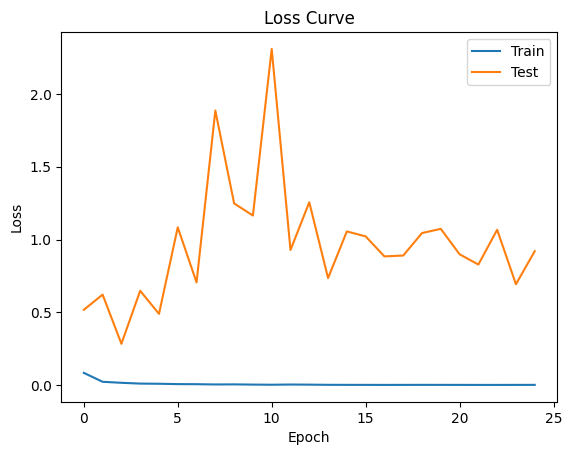

In [ ]:
net = Net()
net.to(device)

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), 
                    lr=0.01,
                    weight_decay=0.01,
                    momentum=0.1)

train_loss_data = []
test_loss_data =[]

def train_model():
    net.train()
    print("Beginning Training:")
    for epoch in range(n_epoch):
        training_running_loss = 0.0
        test_running_loss = 0.0

        for i, data in enumerate(training_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_running_loss += loss.item()
        train_loss_data.append(training_running_loss / len(training_loader))
        
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                test_running_loss += criterion(outputs, labels).item()
            
            test_loss_data.append(test_running_loss / len(test_loader))   
        
        
        print(f'Epoch: {epoch+1}, loss: {training_running_loss}')
    print('Finished Training')

train_model()

plt.plot(train_loss_data, label='Train')
plt.plot(test_loss_data, label='Test')

plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Save the model

In [47]:
PATH = './melspec4_net.pth'

In [48]:
torch.save(net.state_dict(), PATH)

### Evaluating Model Accuracy

In [49]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
net.to(device)
net.eval()


Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=43648, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=1, bias=True)
)

In [50]:
threshold = 0.5

def predict(path):
    outputs = net(file_to_spec_tensor(path).to(device).unsqueeze(0))
    return (outputs >= threshold).item()

In [ ]:
# You can test certain exaples or files using this function
# print(predict("../data/The Fake-or-Real (FoR) Dataset (deepfake audio)/training/file36.wav"))

In [52]:
correct = 0
total = 0
predictions = []
false_positives = []
false_negatives = []
true_positives = []
true_negatives = []

with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        predicted = (outputs >= threshold)

        total += labels.size(0)
        check = predicted == labels
        for j in range(len(check)):
            if predicted[j] != labels[j]:
                if labels[j] == 0:
                    false_positives.append(test_spectrograms[i + j])
                else:
                    false_negatives.append(test_spectrograms[i + j])
            else:
                if labels[j] == 0:
                    true_positives.append(test_spectrograms[i + j])
                else:
                    true_negatives.append(test_spectrograms[i + j])

        correct += check.sum().item()

        predictions.extend(predicted.cpu().detach().numpy())

print(f'Accuracy: {100 * correct // total} %')


Accuracy: 87 %


In [53]:
predictions = np.array(predictions)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     66252
           1       0.51      0.95      0.67      9619

    accuracy                           0.88     75871
   macro avg       0.75      0.91      0.80     75871
weighted avg       0.93      0.88      0.89     75871



### Visualize model network

In [35]:
from torchviz import make_dot

data = next(iter(training_loader))
# print(data.shape) # torch.Size([32, 1, 128, 94])


make_dot(net(data[0].to(device)), params=dict(list(net.named_parameters()))).render("rnn_torchviz", format="svg")


'rnn_torchviz.svg'

![Description of the image](../images/rnn_torchviz.svg)


# Generating a Confusion Matrix

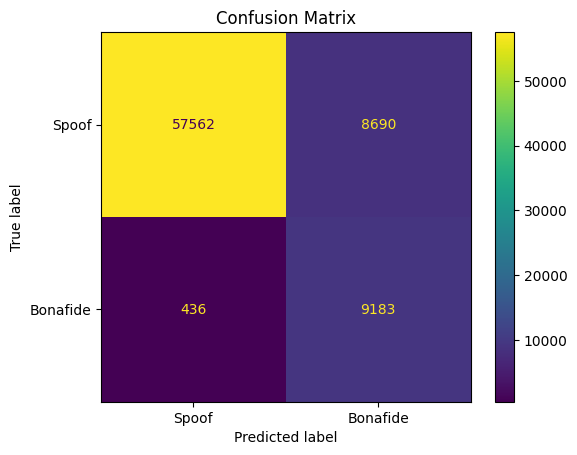

In [54]:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Spoof", "Bonafide"])

disp.plot()
plt.title("Confusion Matrix")
plt.show()

### Visualizing False Positives/False Negatives



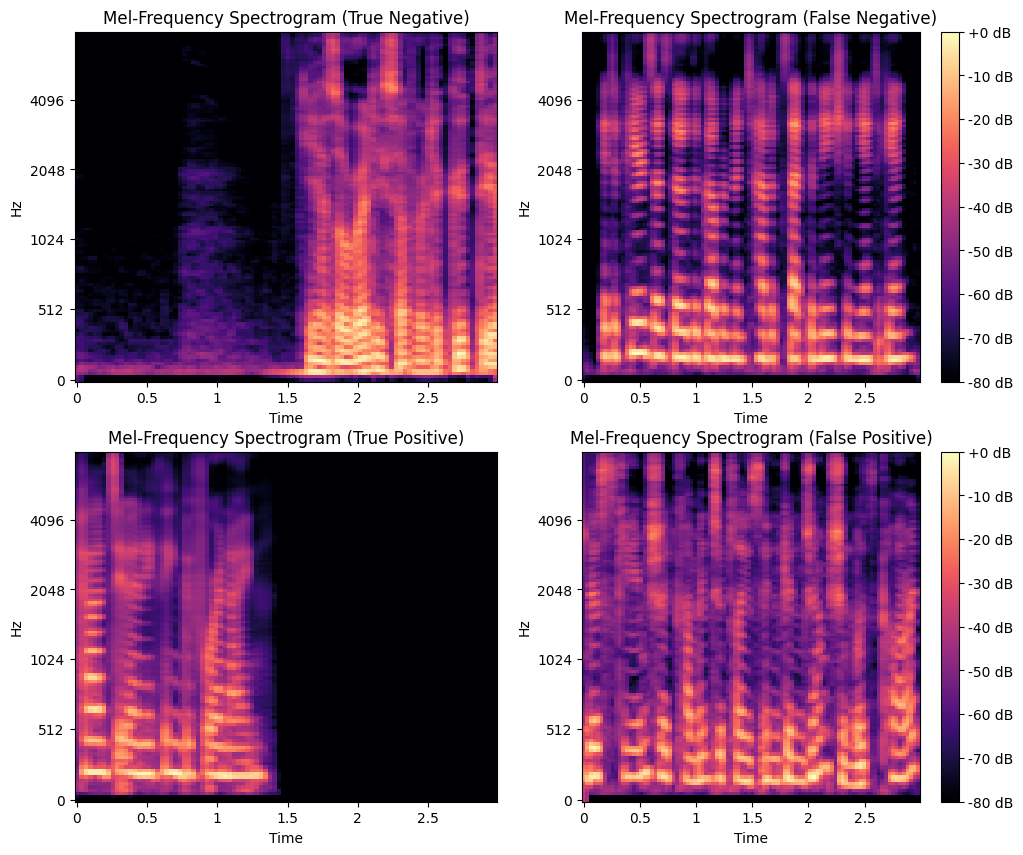

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

def plot_mfcc(spect, row, col, title='Mel-frequency spectrogram', colorbar=False):
    
    img = librosa.display.specshow(spect, x_axis='time', y_axis='mel', sr=16000, fmax=8000, ax=ax[row][col])
    if colorbar:
        fig.colorbar(img, ax=ax[row][col], format='%+2.0f dB')
    ax[row][col].set(title=title)

plot_mfcc(true_negatives[0], 0, 0, "Mel-Frequency Spectrogram (True Negative)", False)
plot_mfcc(false_negatives[0], 0, 1, "Mel-Frequency Spectrogram (False Negative)", True)
plot_mfcc(true_positives[0], 1, 0, "Mel-Frequency Spectrogram (True Positive)", False)
plot_mfcc(false_positives[0], 1, 1, "Mel-Frequency Spectrogram (False Positive)", True)


### Visualize Kernels

In [ ]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
n,c,w,h = tensor.shape

if allkernels: tensor = tensor.view(n*c, -1, w, h)
elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

rows = np.min((tensor.shape[0] // nrow + 1, 64))    
grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
plt.figure( figsize=(nrow,rows) )
plt.imshow(grid.numpy().transpose((1, 2, 0)))


if __name__ == "__main__":
layer = 1
filter = model.features[layer].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()